In [1]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tqdm import tqdm



In [2]:
BASE_DIR = 'D:/Python/image captioning dataset'
WORKING_DIR = 'D:/Python/Deep-Learning/Image Captioning Tensorflow (LSTM+CNN+VGG16)'
model_path = 'D:/Python/Deep-Learning/Image Captioning Tensorflow (LSTM+CNN+VGG16)/best_model.keras'
features_file = 'D:/Python/Deep-Learning/Image Captioning Tensorflow (LSTM+CNN+VGG16)/features/features.pkl'

## EXTRACT IMAGE FEATURES

In [3]:
# Load VGG16 model
model = VGG16()
# Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
import os

import pickle

try:
    # Attempt to load the features from the file
    with open(features_file, 'rb') as f:
        features = pickle.load(f)
    print("Features loaded successfully.")

except FileNotFoundError:
    print("Features file not found. Generating features...")
# Extract features from image
    features = {}
    directory = os.path.join(BASE_DIR, 'Images')

    for img_name in tqdm(os.listdir(directory)):
        #load image from file
        img_path = directory + '/' + img_name
        image = load_img(img_path, target_size=(224,224))
        #convert image pixels to numpy array
        image = img_to_array(image)
        #reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        #preprocess image for vgg
        image = preprocess_input(image)
        #extract features
        feature = model.predict(image, verbose=0)
        #get image ID
        image_id = img_name.split('.')[0]
        #store feature
        features[image_id] = feature
        pickle.dump(features, open(os.path.join('D:/Python/Deep-Learning/Image Captioning Tensorflow (LSTM+CNN+VGG16)/features', 'features.pkl'), 'wb'))

Features loaded successfully.


In [5]:
#load features from pickle
with open(os.path.join(features_file), 'rb') as f:
    features = pickle.load(f)

## Load the captions data

In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r', encoding='utf-8') as f:
    next(f)
    captions_doc = f.read()

In [7]:
#create mapping of image to caption
mapping = {}
#process lines
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma(,)
    tokens = line.split(',')
    if len(line)<2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    #remove extension from image ID
    image_id = image_id.split('.')[0]
    #convert caption list to string
    caption = "".join(caption)
    #create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)    

100%|██████████| 40456/40456 [00:00<00:00, 1036723.99it/s]


In [8]:
len(mapping)

8091

## Preprocess Text Data

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at a time
            caption = captions[i]
            #preprocessing steps
            #CNN lain selain VGG16
            #convert to lowercase
            caption = caption.lower()
            #replace digits, special chars, etc
            caption = caption.replace('[A-Za-z]','')
            #delete additional spaces
            caption = caption.replace('\s+',' ')
            #add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [10]:
#before preprocess of text
mapping['1000268201_693b08cb0e']

['Seorang anak berpakaian merah muda sedang menaiki tangga di jalan masuk.',
 'Seorang gadis memasuki sebuah bangunan kayu.',
 'Seorang gadis kecil naik ke rumah bermain kayu.',
 'Seorang gadis kecil menaiki tangga menuju rumah bermainnya.',
 'Seorang gadis kecil berpakaian merah muda masuk ke kabin kayu.']

In [11]:
#preprocess the text
clean(mapping)

In [12]:
#after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq seorang anak berpakaian merah muda sedang menaiki tangga di jalan masuk. endseq',
 'startseq seorang gadis memasuki sebuah bangunan kayu. endseq',
 'startseq seorang gadis kecil naik ke rumah bermain kayu. endseq',
 'startseq seorang gadis kecil menaiki tangga menuju rumah bermainnya. endseq',
 'startseq seorang gadis kecil berpakaian merah muda masuk ke kabin kayu. endseq']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

In [15]:
all_captions[:10]

['startseq seorang anak berpakaian merah muda sedang menaiki tangga di jalan masuk. endseq',
 'startseq seorang gadis memasuki sebuah bangunan kayu. endseq',
 'startseq seorang gadis kecil naik ke rumah bermain kayu. endseq',
 'startseq seorang gadis kecil menaiki tangga menuju rumah bermainnya. endseq',
 'startseq seorang gadis kecil berpakaian merah muda masuk ke kabin kayu. endseq',
 'startseq seekor anjing hitam dan anjing tutul sedang berkelahi endseq',
 'startseq seekor anjing hitam dan anjing tiga warna bermain satu sama lain di jalan. endseq',
 'startseq seekor anjing hitam dan seekor anjing putih dengan bintik-bintik coklat saling menatap di jalan. endseq',
 'startseq dua anjing dari ras berbeda saling memandang di jalan. endseq',
 'startseq dua anjing di trotoar bergerak menuju satu sama lain. endseq']

In [16]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

6337

In [18]:
#get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

36

## Train test split

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train  = image_ids[:split]
test = image_ids[split:]

In [20]:
# startseq girl going into wooden building endseq
#           X               y
# startseq                 girl
# startseq girl            going
# startseq girl going      into
# .............................
# startseq girl going into wooden building endseq

In [21]:
import numpy as np

#create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            #process each caption
            for caption in captions:
                #encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs (X input, y Output)
                for i in range(1, len(seq)):
                    #split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    #pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    #encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    #store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [22]:
import os
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from keras.utils import plot_model

def build_model():
    # Define your model architecture here
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

if os.path.exists(model_path):
    print("Using the existing model on directory")
    # Load your existing model if it exists
    model = load_model(model_path)
else:
    # Build the model
    model = build_model()

# Plot the model
plot_model(model, show_shapes=True)


Using the existing model on directory
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
import os

if os.path.exists(model_path):
    print("Using the existing model on directory")
else:
    #train the model
    epochs = 15
    batch_size = 64
    steps = len(train) // batch_size
    
    for i in range(epochs):
        
        generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
            

Using the existing model on directory


In [24]:
import os
from tensorflow.keras.models import load_model

if os.path.exists(model_path):
    model = load_model(model_path)
    print("Model loaded successfully")
else:
    # save the model
    model.save('D:/Python/Deep-Learning/Image Captioning Tensorflow (LSTM+CNN+VGG16)/best_model.keras')

Model loaded successfully


Generate Caption for the Image

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
#generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        #predict next word
        yhat = model.predict([image, sequence], verbose=0)
        #get index with high probability
        yhat = np.argmax(yhat)
        #convert index to word
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        #append word as input for generating next word
        in_text += " " + word
        #stop if reach end tag
        if word == 'endseq':
            break
    return in_text

In [27]:
from nltk.translate.bleu_score import corpus_bleu
#validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    #get actual caption
    captions = mapping[key]
    #predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    #split to words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    #append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
#calc BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


100%|██████████| 810/810 [10:52<00:00,  1.24it/s]


BLEU-1: 0.563279
BLEU-2: 0.366245


## Visualize the results

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    if image_id in mapping:
        captions = mapping[image_id]
        print('-------------------------Actual----------------------')
        for caption in captions:
            print(caption)
        # Caption prediction
        y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
        print('------------------------Predicted---------------------')
        print(y_pred)
    else:
        print(f"Image ID '{image_id}' not found in the mapping dictionary.")

    plt.imshow(image)

-------------------------Actual----------------------
startseq seekor kuda pirang dan seorang gadis pirang dengan kaus hitam sedang menatap api di dalam tong. endseq
startseq seorang gadis dan kudanya berdiri di dekat api unggun. endseq
startseq seorang gadis memegang tali pengikat kuda di belakang api unggun. endseq
startseq seorang pria seorang gadis dan dua ekor kuda berada di dekat api unggun. endseq
startseq dua orang dan dua kuda mengawasi api. endseq
------------------------Predicted---------------------
startseq seorang pria dan seekor kuda dan seekor kuda endseq


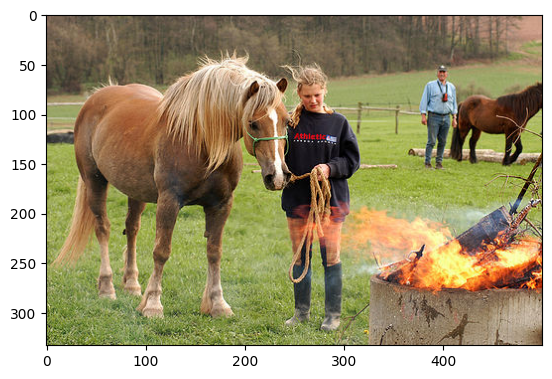

In [29]:
generate_caption("10815824_2997e03d76.jpg")